# Dimensionality Reduction Example

Using the IMDB data, feature matrix and apply dimensionality reduction to this matrix via PCA and SVD.

In [1]:
%matplotlib inline

In [2]:
import json
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix

from sklearn.neighbors import DistanceMetric

from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances

In [5]:
# Let's restrict ourselves just to US titles
relevant_title_df = pd.read_csv("../data/us_relevant_titles.csv")

# And create a set of just these titles, so we can filter them
relevant_title_set = set(relevant_title_df["title"])

In [6]:
actor_id_to_name_map = {}     # Map Actor IDs to actor names
actor_id_to_index_map = {}    # Map actor IDs to a unique index of known actors
index_to_actor_ids = []       # Array mapping unique index back to actor ID (invert of actor_id_to_index_map)

index_counter = 0    # Unique actor index; increment for each new actor
known_actors = set()

movie_actor_list = [] # List of all our movies and their actors

test_count = 0
with open("../data/imdb_recent_movies.json", "r") as in_file:
    for line in in_file:
        
        this_movie = json.loads(line)
        
        # Restrict to American movies
        if this_movie["title_name"] not in relevant_title_set:
            continue
            
        # Keep track of all the actors in this movie
        for actor_id,actor_name in zip(this_movie['actor_ids'],this_movie['actor_names']):
            
            # Keep names and IDs
            actor_id_to_name_map[actor_id] = actor_name
            
            # If we've seen this actor before, skip...
            if actor_id in known_actors:
                continue
                
            # ... Otherwise, add to known actor set and create new index for them
            known_actors.add(actor_id)
            actor_id_to_index_map[actor_id] = index_counter
            index_to_actor_ids.append(actor_id)
            index_counter += 1
            
        # Finished with this film
        movie_actor_list.append({
            "movie": this_movie["title_name"],
            "actors": set(this_movie['actor_ids']),
            "genres": this_movie["title_genre"]
        })

In [7]:
print("Known Actors:", len(known_actors))

Known Actors: 161996


## Generate Same DataFrame using Sparse Matrics

The above will break if you have too much data. We can get around that partially with sparse matrices, where we only store the non-zero elements of the feature matrix and their indices.

In [8]:
# With sparse matrix, initialize to size of Movies x Actors of 0s
matrix_sparse = lil_matrix((len(movie_actor_list), len(known_actors)), dtype=bool)

# Update the matrix, movie by movie, setting non-zero values for the appropriate actors
for row,movie in enumerate(movie_actor_list):   
    for actor_id in movie["actors"]:
        this_index = actor_id_to_index_map[actor_id]
        matrix_sparse[row,this_index] = 1

In [9]:
df = pd.DataFrame.sparse.from_spmatrix(
    matrix_sparse, 
    index=[m["movie"] for m in movie_actor_list],
    columns=[index_to_actor_ids[i] for i in range(len(known_actors))]
)
df

,nm0001379,nm0000953,nm0864851,nm0933983,nm0329491,nm0000123,nm0000221,nm0307255,nm0635649,nm0033458,...,nm10823679,nm1290838,nm5580678,nm8370368,nm0578248,nm2952127,nm3611859,nm9445072,nm8594703,nm8680851
The Other Side of the Wind,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Naked Monster,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Grizzly II: Revenge,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chief Zabu,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Life Without Sara Amat,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
The Rehearsal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
Safeguard,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Coven,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
top_k_actors = 1000

In [12]:
# Extract the most frequent actors, so we can deal with a reasonable dataset size
actor_df = df.sum(axis=0)
top_actors = set(actor_df.sort_values().tail(top_k_actors).index)

In [14]:
# Restrict the data frame to just the movies containing
#. the top k actors
reduced_df = df[top_actors] # restrict to just these top actors

# throw away movies that don't have any of these actors
reduced_df = reduced_df.loc[reduced_df.sum(axis=1) > 0] 

reduced_df

,nm0864779,nm0199939,nm0000243,nm0875244,nm2502988,nm0625789,nm0479471,nm3024530,nm0004747,nm0868381,...,nm0252230,nm0000661,nm1128418,nm0000179,nm0924684,nm2246282,nm0191412,nm0001288,nm0749263,nm0936403
Grizzly II: Revenge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
In the Mood for Love,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fox Hunting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mountain Quest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enemy Lines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Manoharam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Apply PCA to Feature Matrix

In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA 

In [17]:
matrix_dense = reduced_df.to_numpy()
reduced_df

,nm0864779,nm0199939,nm0000243,nm0875244,nm2502988,nm0625789,nm0479471,nm3024530,nm0004747,nm0868381,...,nm0252230,nm0000661,nm1128418,nm0000179,nm0924684,nm2246282,nm0191412,nm0001288,nm0749263,nm0936403
Grizzly II: Revenge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
In the Mood for Love,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fox Hunting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mountain Quest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enemy Lines,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Manoharam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
pca = PCA(n_components=2)

In [19]:
pca.fit(matrix_dense)

PCA(n_components=2)

In [20]:
matrix_reduced = pca.transform(matrix_dense)

In [21]:
np.mean(matrix_reduced, axis=0)

array([5.61339781e-18, 1.05798195e-18])

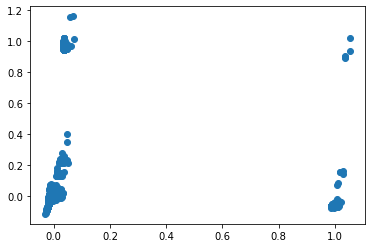

In [22]:
plt.scatter(matrix_reduced[:,0], matrix_reduced[:,1])

In [23]:
counter = 0
for index in np.argwhere((matrix_reduced[:,0] > 1.0) & (matrix_reduced[:,1] > 0.8)):
    movie_title = reduced_df.iloc[index[0]].name
    for this_movie in [m for m in movie_actor_list if m['movie'] == movie_title]:

        print(this_movie["movie"])
        print("\tGenres:", ", ".join(this_movie["genres"]))
        print("\tActors:", ", ".join([actor_id_to_name_map[actor] for actor in this_movie["actors"]]))

    counter += 1
    if counter > 10:
        print("...")
        break    

The Alternate
	Genres: Action, Drama
	Actors: Ice-T, Michael Madsen, Eric Roberts, Bryan Genesse
Luck of the Draw
	Genres: Crime, Drama, Thriller
	Actors: Dennis Hopper, Michael Madsen, Eric Roberts, James Marshall
Skin Traffik
	Genres: Action, Crime
	Actors: Mickey Rourke, Michael Madsen, Eric Roberts
Mission: The Prophet
	Genres: Action, Thriller
	Actors: Eric Roberts, Alexander Nevsky, Stephen Baldwin, Casper Van Dien, Oded Fehr, Michael Madsen, Aleksey Chadov
Beyond the Game
	Genres: Action, Drama
	Actors: Danny Trejo, Mark Dacascos, Michael Madsen, Eric Roberts


In [24]:
counter = 0
for index in np.argwhere((matrix_reduced[:,0] < 0.1) & (matrix_reduced[:,1] < 0.1)):
    movie_title = reduced_df.iloc[index[0]].name
    for this_movie in [m for m in movie_actor_list if m['movie'] == movie_title]:

        print(this_movie["movie"])
        print("\tGenres:", ", ".join(this_movie["genres"]))
        print("\tActors:", ", ".join([actor_id_to_name_map[actor] for actor in this_movie["actors"]]))

    counter += 1
    if counter > 10:
        print("...")
        break    

Grizzly II: Revenge
	Genres: Horror, Music, Thriller
	Actors: George Clooney, Charlie Sheen
Crime and Punishment
	Genres: Drama
	Actors: Crispin Glover, John Hurt
For the Cause
	Genres: Action, Adventure, Drama
	Actors: Dean Cain, Justin Whalin, Thomas Ian Griffith
For the Cause
	Genres: Drama
	Actors: Jerod Haynes, Anthony Lemay, Eugene Parker
For the Cause
	Genres: Comedy
	Actors: Abdelghani Sannak, Ramzi Maqdisi, Jeremy Banster
Gang
	Genres: Action, Crime, Drama
	Actors: Jackie Shroff, Jaaved Jaaferi, Nana Patekar, Kumar Gaurav
Gang
	Genres: Action
	Actors: Ji-Hyuk Cha
In the Mood for Love
	Genres: Drama, Romance
	Actors: Tony Chiu-Wai Leung, Tung Cho 'Joe' Cheung, Siu Ping-Lam
Chinese Coffee
	Genres: Drama
	Actors: Al Pacino, Jerry Orbach
Fandango
	Genres: \N
	Actors: Moritz Bleibtreu, Lars Rudolph, Richy Müller
Fandango
	Genres: Drama
	Actors: Arturo Meseguer, Martín Zapata
The Dancer Upstairs
	Genres: Crime, Drama, Thriller
	Actors: Juan Diego Botto, Javier Bardem
Don's Plum
	Gen

In [32]:
comp1_genre_map = {}
comp1_actor_map = {}

comp1_counter = 0
for index in np.argwhere((matrix_reduced[:,0] > 1.0) & (matrix_reduced[:,1] < 0.2)):
    movie_title = reduced_df.iloc[index[0]].name
    for this_movie in [m for m in movie_actor_list if m['movie'] == movie_title]:
        for g in this_movie["genres"]:
            comp1_genre_map[g] = comp1_genre_map.get(g, 0) + 1
        for a in [actor_id_to_name_map[actor] for actor in this_movie["actors"]]:
            comp1_actor_map[a] = comp1_actor_map.get(a, 0) + 1

    comp1_counter += 1
    
print("Movies in Component 1:", comp1_counter)

print("Genres:")
for g in sorted(comp1_genre_map, key=comp1_genre_map.get, reverse=True)[:10]:
    print("\t", g, comp1_genre_map[g])
print("Actors:")
for a in sorted(comp1_actor_map, key=comp1_actor_map.get, reverse=True)[:10]:
    print("\t", a, comp1_actor_map[a])

Movies in Component 1: 31
Genres:
	 Drama 18
	 Action 16
	 Thriller 15
	 Horror 12
	 Crime 7
	 Mystery 5
	 Fantasy 4
	 Sci-Fi 4
	 Adventure 3
	 Comedy 2
Actors:
	 Eric Roberts 31
	 Vernon Wells 4
	 Armand Assante 4
	 Martin Kove 4
	 Tom Sizemore 4
	 Gary Daniels 3
	 Danny Trejo 2
	 Craig Sheffer 2
	 Robert Loggia 2
	 William McNamara 2


In [26]:
comp2_genre_map = {}
comp2_actor_map = {}

comp2_counter = 0
for index in np.argwhere((matrix_reduced[:,0] < 0.1) & (matrix_reduced[:,1] < 0.1)):
    movie_title = reduced_df.iloc[index[0]].name

    for this_movie in [m for m in movie_actor_list if m['movie'] == movie_title]:
        for g in this_movie["genres"]:
            comp2_genre_map[g] = comp2_genre_map.get(g, 0) + 1
        for a in [actor_id_to_name_map[actor] for actor in this_movie["actors"]]:
            comp2_actor_map[a] = comp2_actor_map.get(a, 0) + 1

    comp2_counter += 1
    
print("Movies in Component 2:", comp2_counter)

print("Genres:")
for g in sorted(comp2_genre_map, key=comp2_genre_map.get, reverse=True)[:10]:
    print("\t", g, comp2_genre_map[g])
print("Actors:")
for a in sorted(comp2_actor_map, key=comp2_actor_map.get, reverse=True)[:10]:
    print("\t", a, comp2_actor_map[a])

Movies in Component 2: 18069
Genres:
	 Drama 17274
	 Comedy 7327
	 Thriller 5586
	 Action 5152
	 Crime 3959
	 Romance 3727
	 Horror 3165
	 Mystery 2093
	 Adventure 2032
	 Sci-Fi 1190
Actors:
	 Joe Hammerstone 91
	 Tony Devon 85
	 Louis Koo 85
	 Brahmanandam 79
	 Nicolas Cage 69
	 James Franco 68
	 Prakash Raj 65
	 Samuel L. Jackson 63
	 Willem Dafoe 63
	 Simon Yam 62


## Find Similar Movies in Reduced Dimensional Space

In [33]:
query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "The Lord of the Rings: The Fellowship of the Ring"][0]
# query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "Heavy Metal 2000"][0]
# query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "Casino Royale"][0]
# query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "Star Wars: Episode II - Attack of the Clones"][0]
query_idx

18

In [34]:
query_v = matrix_reduced[query_idx,:]

In [35]:
query_v

array([-0.01610857, -0.01206623])

In [36]:
# get distances between all films and query film
distances = pairwise_distances(matrix_reduced, [query_v], metric='euclidean')


In [37]:
distances_df = pd.DataFrame(distances, columns=["distance"])
for idx,row in distances_df.sort_values(by="distance", ascending=True).head(20).iterrows():
    print(idx, reduced_df.iloc[idx].name, row["distance"])

18 The Lord of the Rings: The Fellowship of the Ring 0.0
18220 The Survivor 8.162382436688538e-05
3645 Hail, Caesar! 0.0001608435402804266
8890 Safe House 0.00016519799609192336
4109 R.I.P.D. 0.00016639629282336435
14554 That's It 0.00018100466540261792
4084 In Tranzit 0.0002228872816711862
7144 Iron Man 3 0.00022350965435497395
15201 The Eavesdropper 0.00022602593623175586
8738 The Girl with the Dragon Tattoo 0.0002508798503263284
378 Enemy at the Gates 0.0003106310279272794
747 High Crimes 0.0003244929427035023
5988 Duplicity 0.0003333468791838938
3757 The Prestige 0.0003346862189363745
7503 The Dark Knight Rises 0.0003481988998261881
4610 In the Electric Mist 0.0003502331193559915
17693 Punk Samurai Slash Down 0.00036838087105625904
8141 White as Snow 0.0003751891583244215
778 Taking Sides 0.00039875218494733294
15819 The Poison Rose 0.0004048289859797763
